In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm


import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision
from torchvision import transforms
from torchvision.models import vgg16

%matplotlib inline

device = torch.device('cuda')

In [2]:
class ResidualSeparableBlock(nn.Module):
    def __init__(self, features, kernel=3, padding=1, padding_mode='reflect', **kwargs):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
            nn.ReLU(),
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                features,
                features,
                kernel,
                padding=padding,
                padding_mode=padding_mode,
                groups=features,
                **kwargs
            ),
            nn.Conv2d(features, features, 1, bias=False),
            nn.InstanceNorm2d(features, affine=True),
        )

    def forward(self, x):
        return self.conv_2(self.conv_1(x)) + x


def conv_separable_block(in_features, out_features, kernel=3, stride=1, padding=0, padding_mode='reflect', **kwargs):
    return nn.Sequential(
        nn.Conv2d(
            in_features,
            in_features,
            kernel,
            stride=stride,
            padding=padding,
            padding_mode=padding_mode,
            groups=in_features,
            **kwargs
        ),
        nn.Conv2d(in_features, out_features, 1, bias=False),
        nn.InstanceNorm2d(out_features, affine=True),
        nn.ReLU()
    )


def upconv_separable_block(in_features, out_features, kernel=3, stride=1, padding=0, output_padding=0, **kwargs):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_features,
            in_features,
            kernel,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
            groups=in_features,
            **kwargs
        ),
        nn.ConvTranspose2d(in_features, out_features, 1, bias=False),
        nn.InstanceNorm2d(out_features, affine=True),
        nn.ReLU()
    )


class Activate(nn.Module):
    def forward(self, input: torch.Tensor):
        # return input.clamp(0.0, 1.0)
        return input.tanh().add(1).true_divide(2)


class StyleTransferFast(nn.Module):
    def __init__(self, n_residual=15):
        super().__init__()
        self.n_residual = n_residual
        residual_stack = [ResidualSeparableBlock(64) for _ in range(self.n_residual)]
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            conv_separable_block(32, 64, kernel=3, stride=2, padding=1),
            *residual_stack,
            upconv_separable_block(64, 32, kernel=3, stride=2, padding=1, output_padding=1),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            Activate()
        )

    def forward(self, x):
        return self.layers(x)


class ImageDataset(Dataset):
    def __init__(self, paths):
        self._paths = paths
        self._toTensor = transforms.Compose([
            transforms.ToTensor(),
        ])

    def __getitem__(self, index):
        with Image.open(self._paths[index]) as img:
            sample = img.convert('RGB')
        sample = self._toTensor(sample)
        return sample

    def __len__(self):
        return len(self._paths)


def criterion(outputs, inputs):
    return outputs.sub(inputs).pow(2).mean()


def run_batches(lr_sched, epoch, do_train):
    with torch.set_grad_enabled(do_train):
        model.train(do_train)
        running_loss = 0.0
        processed_count = 0
        opt = lr_sched.optimizer

        batches = tqdm(
            loader,
            desc=('Train E{}' if do_train else 'Validate E{}').format(epoch),
            unit='batch',
            leave=False
        )
        for inputs in batches:
            this_batch_size = inputs.size(0)
            inputs = inputs.to(device)

            with torch.autograd.set_detect_anomaly(False):
                outputs = model(inputs)
                loss_value = criterion(outputs, inputs)
                if do_train:
                    opt.zero_grad()
                    loss_value.backward()
                    opt.step()
            running_loss += loss_value.item() * this_batch_size
            processed_count += this_batch_size
        #if not do_train:
        lr_sched.step(running_loss / processed_count)

    return running_loss / processed_count


def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0)).clip(0, 1)
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def train(epochs = 40, init_lr=1E-3):
    opt = torch.optim.AdamW(
        [p for p in model.parameters() if p.requires_grad == True],
        lr=init_lr,
    )
    lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        factor=0.5,
        patience=2,
        threshold=1e-1,
        verbose=True
    )
    for epoch in range(0, epochs):
        epoch += 1
        loss = run_batches(
            lr_sched,
            epoch,
            True,
        )
        print(f"Epoch {epoch}, loss {loss}")
    return


In [21]:
files = sorted(list(Path("/home/master/Downloads/coco-square").rglob('*.jpg')))
dataset = ImageDataset(files)
loader = DataLoader(
    dataset,
    sampler=RandomSampler(files),
    batch_size=16,
    num_workers=4,
    pin_memory=True,
)
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=2, padding_mode='reflect', bias=False),
    nn.InstanceNorm2d(32, affine=True),
    nn.ReLU(),
    nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
    Activate()
)
model.to(device);

In [22]:
train(10, init_lr=1E-2)

Epoch 1, loss 0.020081729081273078
Epoch 2, loss 0.017465166376531123
Epoch 3, loss 0.01693935330361128
Epoch 4, loss 0.01700430200994015
Epoch     5: reducing learning rate of group 0 to 5.0000e-03.
Epoch 5, loss 0.016730954008549452
Epoch 6, loss 0.016252755512297153
Epoch 7, loss 0.016414970502257348
Epoch     8: reducing learning rate of group 0 to 2.5000e-03.
Epoch 8, loss 0.01619928796738386
Epoch 9, loss 0.015952907606959343
Epoch 10, loss 0.01596892556399107


In [27]:
batch_size,C,H,W = 1,3,512,512
batch = torch.rand(batch_size,C,H,W, device=device, dtype=torch.float32)
out = model(batch)
out.sub(batch).mean()

tensor(-0.0641, device='cuda:0', grad_fn=<MeanBackward0>)

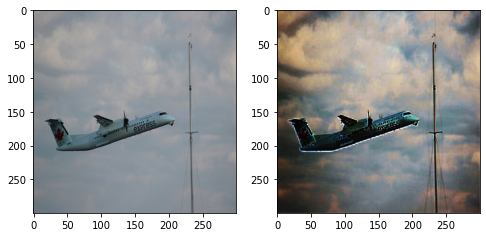

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
random_character = int(np.random.uniform(0, len(dataset)))
im_val = dataset[random_character]
imshow(im_val, plt_ax=ax[0])
imshow(model(im_val.unsqueeze(0).to(device)).detach().cpu().squeeze(0), plt_ax=ax[1])

In [24]:
for m in model.modules():
    print(m)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
  (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (2): ReLU()
  (3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (4): Activate()
)
Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
ReLU()
ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
Activate()


In [28]:
from io import open
from struct import Struct

weights = []
align_to_4byte_numbers = 64
for m in model.modules():
    numel = 0
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        weights.append(m.weight.data)
        numel = weights[-1].numel()
        if m.bias is not None:
            weights.append(m.bias.data)
            numel += weights[-1].numel()
    elif isinstance(m, nn.InstanceNorm2d):
        if m.bias is not None:
            weights.append(m.weight.data)
            numel = weights[-1].numel()
            weights.append(m.bias.data)
            numel += weights[-1].numel()
    if numel % align_to_4byte_numbers > 0:
        weights.append(torch.zeros((align_to_4byte_numbers - numel % align_to_4byte_numbers,)))


ff = Struct("f")
with open("/home/master/CLionProjects/VkStyleLayer/config/weights.bin", "wb") as f:
    for t in weights:
        for num in t.detach().cpu().flatten():
            f.write(ff.pack(num))